In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from collections import defaultdict, Counter
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

# Model imports
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [2]:
with open('target_variable.pickle','rb') as f:
    target = pickle.load(f)

In [3]:
with open('features_initial.pickle','rb') as f2:
    features = pickle.load(f2)

In [4]:
target['high_incidence'] = np.nan

In [5]:
# CDC defines "high incidence" as a county with greater than 10 cases per population of 100,000
cdc_cutoff = 10/100000

In [6]:
# Binning data for classification models
target.high_incidence[target.incidence_rate >= cdc_cutoff] = 1
target.loc[:,'high_incidence'][target.incidence_rate <= cdc_cutoff] = 0

/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Class Imbalance
target.high_incidence.value_counts()/len(target)

0.0    0.859375
1.0    0.140625
Name: high_incidence, dtype: float64

In [1]:
target.head()

NameError: name 'target' is not defined

In [9]:
features.head()

,state,county,DATE,LATITUDE,LONGITUDE,ELEVATION,precip_num_days_over_0.01,precip_num_days_over_0.1,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp
0,Alabama,Autauga County,2010,32.482500,-86.485400,100.300000,120.000000,62.000000,14.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,102.100000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1141.700000,35.05744,17.552706,23.943332,11.181082
1,Alabama,Autauga County,2013,32.825200,-86.416400,107.300000,91.000000,74.000000,20.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,84.800000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1590.100000,35.05744,17.552706,23.943332,11.181082
2,Alabama,Autauga County,2014,32.653850,-86.450900,103.800000,106.000000,74.500000,16.5,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,96.500000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1342.300000,35.05744,17.552706,23.943332,11.181082
3,Alabama,Baldwin County,2010,30.521877,-87.796877,31.723077,111.090909,75.909091,21.0,0.000000,0.000000,0.000000,47.200000,0.000000,253.000000,95.000000,-8.840000,0.000000,0.000000,91.172727,38.700000,-0.660000,-2.900000,-4.850000,-6.700000,-9.526784,-1.200000,-2.720000,-5.080000,-9.400000,-9.766667,1497.054545,0.00000,18.848000,24.846000,12.854000
4,Alabama,Baldwin County,2011,30.516725,-87.801650,29.991667,95.300000,64.500000,14.1,0.673203,0.476935,0.000000,21.666667,0.000000,280.000000,97.250000,-5.933333,22.512255,25.230208,95.080000,38.600000,-1.400000,-2.500000,-5.256631,-7.443868,-9.526784,-2.033333,-2.766667,-4.600000,-6.700000,-10.532082,1218.360000,35.05744,20.060000,26.047500,14.013333


In [10]:
df = features.merge(target, left_on=['state','county','DATE'],right_on=['STNAME','CTYNAME','year'])

In [11]:
# Dropping Hawaii due to missing climate data and geographical isolation to contiguous U.S.
df = df[df.state != 'Hawaii']

In [12]:
# Merge dropped roughly equal amounts of 0 and 1
df.high_incidence.value_counts()/ len(df)

0.0    0.857209
1.0    0.142791
Name: high_incidence, dtype: float64

In [13]:
# Percentage of null values in each column - NONE!
df.isnull().sum()/len(df)*100

state                         0.0
county                        0.0
DATE                          0.0
LATITUDE                      0.0
LONGITUDE                     0.0
ELEVATION                     0.0
precip_num_days_over_0.01     0.0
precip_num_days_over_0.1      0.0
precip_num_days_over_1        0.0
snow_depth_num_days_over_1    0.0
snowfall_num_days_over_1      0.0
max_temp_num_days_under_0     0.0
min_temp_num_days_under_32    0.0
max_temp_num_days_under_32    0.0
max_temp_num_days_over_70     0.0
max_temp_num_days_over_90     0.0
min_temp_year                 0.0
max_snow_depth_year           0.0
max_snowfall_year             0.0
max_precip_day                0.0
max_temp_year                 0.0
first_min_temp_under_32       0.0
first_min_temp_under_28       0.0
first_min_temp_under_24       0.0
first_min_temp_under_20       0.0
first_min_temp_under_16       0.0
last_min_temp_under_32        0.0
last_min_temp_under_28        0.0
last_min_temp_under_24        0.0
last_min_temp_

In [14]:
df.drop(columns=['LATITUDE','LONGITUDE','STNAME','CTYNAME','year','incidence_rate'], inplace=True)

In [15]:
df.columns = df.columns.str.replace('.','',)

## Feature Engineering

In [81]:
# plt.figure(figsize=(13,10))
# sns.heatmap(df.corr(), cmap="seismic")

In [82]:
# df.corr()[(df.corr()> .9) & (df.corr()<1)]

In [83]:
# df = df.merge(land_df, left_on=['Stabrev','Ctyname'], right_on=['USPS','NAME']).drop(columns=['USPS','NAME','GEOID','ANSICODE','INTPTLAT','INTPTLONG'])

## Data Preprocessing

### Formatting designer matrix and target variable

In [161]:
# def ols_formula(df, dependent_var, *excluded_cols):
#     '''
#     Generates the R style formula for statsmodels (patsy) given
#     the dataframe, dependent variable and optional excluded columns
#     as strings
#     '''
#     df_columns = list(df.columns.values)
#     df_columns.remove(dependent_var)
#     for col in excluded_cols:
#         df_columns.remove(col)
#     return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [162]:
# # Using patsy to set up data for modeling
# formula = ols_formula(df,'high_incidence','county','state','DATE')
# y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

In [16]:
X = df.drop(columns=['high_incidence','county','state','DATE'])

In [17]:
y = df['high_incidence']

### Creating Test/Train Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.5, random_state=42,stratify=y_train)

### Standardizing Splits

In [30]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

### Oversampling/ Undersampling Splits

In [20]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_scaled_resampled, y_scaled_resampled = ros.fit_sample(X_scaled_train,y_train) # 
Counter(y_resampled)

Counter({0.0: 14921, 1.0: 14921})

In [21]:
smo = SMOTE(random_state=42)
X_smoted, y_smoted = smo.fit_sample(X_train,y_train)
X_scaled_smoted, y_scaled_smoted = smo.fit_sample(X_scaled_train,y_train)
Counter(y_smoted)

Counter({0.0: 14921, 1.0: 14921})

In [22]:
ada = ADASYN(random_state=42)
X_adasyn, y_adasyn = ada.fit_sample(X_train,y_train)
X_scaled_adasyn, y_scaled_adasyn = ada.fit_sample(X_scaled_train,y_train)
Counter(y_adasyn)

Counter({0.0: 14921, 1.0: 14634})

In [322]:
with open('X_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [323]:
with open('y_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [324]:
with open('X_scaled_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [325]:
with open('y_scaled_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [23]:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_sample(X_train,y_train)
X_scaled_under, y_scaled_under = rus.fit_sample(X_scaled_train,y_train)
Counter(y_under)

Counter({0.0: 2486, 1.0: 2486})

In [24]:
train_sets = [(X_train, y_train),(X_resampled, y_resampled),
              (X_smoted, y_smoted),(X_adasyn, y_adasyn),(X_under, y_under)]

scaled_train_sets = [(X_scaled_train, y_train),(X_scaled_resampled, y_scaled_resampled),
              (X_scaled_smoted, y_scaled_smoted),(X_scaled_adasyn, y_scaled_adasyn),(X_scaled_under, y_scaled_under)]

## K-Nearest Neighbors
- Hyperparameter: k

0.9203990503036102

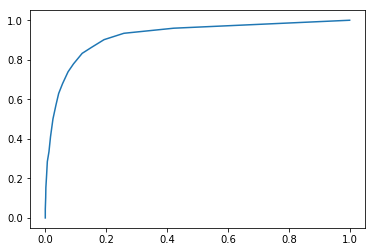

In [139]:
# ROC Curve
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_scaled_train, y_train)
y_pred = knn.predict_proba(X_scaled_test)[:,1]
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(knn_fpr, knn_tpr)
metrics.roc_auc_score(y_test, y_pred)

In [46]:
# with open('knn_2.pickle','wb') as f:
#     pickle.dump(knn, f)

## Logistic Regression
- Hyper parameters: C, penalty

In [354]:
# Manual Cross Fold Validation for Hyper Parameter Tuning- Logistic Regression
C_values= np.logspace(-3,3,7)
penalty_values = ['l1','l2']

lr_final_scores = []

for features,target in scaled_train_sets:
    all_scores = []
    parameter_combs = []
    for C in C_values:
        for p in penalty_values:
            lr = LogisticRegression(solver='liblinear',C=C,penalty=p,random_state=42, n_jobs=-1)
            scores = cross_val_score(lr, features,target, cv=5, scoring='roc_auc',n_jobs=-1)
            all_scores.append(np.mean(scores))
            parameter_combs.append((C,p))
        best_index = np.argmax(all_scores)
    
    print(f'The best hyper parameters are: {parameter_combs[best_index]}')
    print(f'The best score is: {all_scores[best_index]}')
    lr_final_scores.append({(parameter_combs[best_index],all_scores[best_index],best_index):all_scores})

The best hyper parameters are: (1.0, 'l2')
The best score is: 0.9090517106082888
The best hyper parameters are: (10.0, 'l2')
The best score is: 0.9113795541088583
The best hyper parameters are: (10.0, 'l2')
The best score is: 0.9172798262046452
The best hyper parameters are: (1.0, 'l1')
The best score is: 0.8806567750454508
The best hyper parameters are: (10.0, 'l1')
The best score is: 0.9028270329706813


In [374]:
with open('lr_final_scores.pickle', 'wb') as f:
    pickle.dump(lr_final_scores,f)

In [375]:
with open('lr_parameter_combs.pickle', 'wb') as f:
    pickle.dump(lr_parameter_combs,f)

In [356]:
lr_parameter_combs = parameter_combs.copy() # saving copy of logistic regression parameter grid

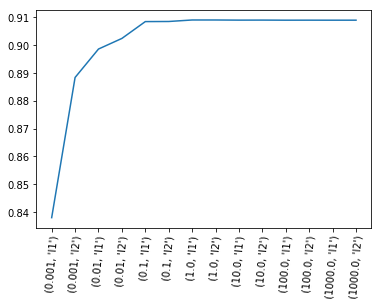

In [258]:
# ROC AUC vs. hyper parameters
sns.lineplot([x for x in range(14)], all_scores)
plt.xticks([x for x in range(14)], labels=parameter_combs, rotation=85);

0.9159619689842384

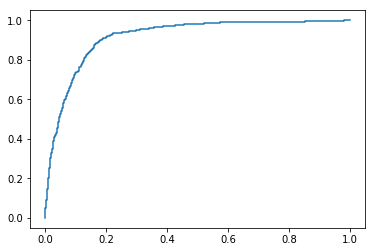

In [140]:
# ROC Curve
lr = LogisticRegression(solver='liblinear',C=1,penalty='l1',random_state=42)
lr.fit(X_scaled_train, y_train)
y_pred = lr.predict_proba(X_scaled_test)[:,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(lr_fpr,lr_tpr)
metrics.roc_auc_score(y_test, y_pred)

0.9149964759720857

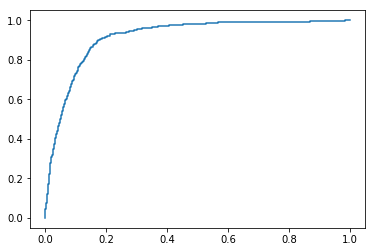

In [128]:
# ROC Curve
lr = LogisticRegression(solver='liblinear',C=10,penalty='l2',random_state=42)
lr.fit(X_scaled_smoted, y_scaled_smoted)
y_pred = lr.predict_proba(X_scaled_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr, tpr)
metrics.roc_auc_score(y_test, y_pred)

In [425]:
# with open('lr_1.pickle','wb') as f:
#     pickle.dump(lr, f)

## Naive Bayes
- Hyper parameters: None

In [351]:
gnb_final_scores = []
gnb = GaussianNB()
for x,y in train_sets:
    scores = cross_val_score(gnb, x,y, cv=5, scoring='roc_auc')
    print(f'Final Score: {np.mean(scores)}')
    gnb_final_scores.append(np.mean(scores))

Final Score: 0.8707470452952288
Final Score: 0.8715940015292626
Final Score: 0.8853017660426536
Final Score: 0.8536787141178387
Final Score: 0.8658574225990655


0.8761389429470022

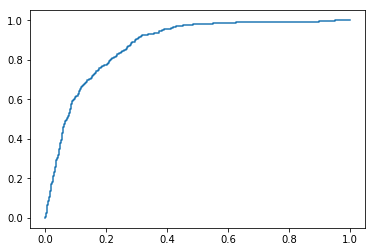

In [143]:
# ROC Curve
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict_proba(X_test)[:,1]
gnb_fpr, gnb_tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(gnb_fpr,gnb_tpr)
metrics.roc_auc_score(y_test, y_pred)

In [315]:
# with open('gnb_2.pickle','wb') as f:
#     pickle.dump(gnb, f)

## Support Vector Machines
- Hyper parameters: C, gamma

In [370]:
# Manual Cross Fold Validation for Hyper Parameter Tuning- SVM
C_values= np.logspace(-2,2,5)
gammas = np.logspace(-2,2,5)

svm_final_scores = []

for features,target in scaled_train_sets:
    all_scores = []
    parameter_combs = []
    for C in C_values:
        for g in gammas:
            svc = SVC(C=C,gamma=g,random_state=42, kernel='rbf', probability=True)
            scores = cross_val_score(svc, features,target, cv=5, scoring='roc_auc',verbose=10, n_jobs=-1)
            all_scores.append(np.mean(scores))
            parameter_combs.append((C,g))
    best_index = np.argmax(all_scores)
    print(f'The best hyper parameters are: {parameter_combs[best_index]}')
    print(f'The best score is: {all_scores[best_index]}')
    svm_final_scores.append({(parameter_combs[best_index],all_scores[best_index],best_index):all_scores})

svm_parameter_combs = parameter_combs.copy() # Saving a copy of the parameter grid for svm

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.5s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   39.6s remaining:   26.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   44.4s remaining:   29.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.7mi

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.6s remaining:   37.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.8min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.6min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8

The best hyper parameters are: (10.0, 0.01)
The best score is: 0.9319324647311248


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.4min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.5min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

The best hyper parameters are: (100.0, 10.0)
The best score is: 0.9990879328886283


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.0min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.0min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 18.0min remaining: 27.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 18.2min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

The best hyper parameters are: (10.0, 1.0)
The best score is: 0.9947917480744277


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.2min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.1min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 17.9min remaining: 26.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 17.9min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

The best hyper parameters are: (10.0, 1.0)
The best score is: 0.9867079215435466


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurren

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   

The best hyper parameters are: (10.0, 0.01)
The best score is: 0.9274697095263553


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


In [371]:
svm_final_scores

[{((10.0, 0.01), 0.9319324647311248, 15): [0.9069278218990376,
   0.8985409754533087,
   0.8865974778404931,
   0.6703642354833004,
   0.539690345867403,
   0.9079247189826406,
   0.9055456317902418,
   0.8868427464957179,
   0.6853262406549756,
   0.5440111226562794,
   0.9254804790914359,
   0.9179233043981414,
   0.8873046881124551,
   0.7008146369490182,
   0.5461407808530865,
   0.9319324647311248,
   0.9123584471974284,
   0.8803568324897088,
   0.7030674108573812,
   0.5465052792071228,
   0.9277277979343893,
   0.9035150256398111,
   0.8744113170868015,
   0.7022151433507882,
   0.5463729837800877]},
 {((100.0, 10.0), 0.9990879328886283, 23): [0.8991330002084394,
   0.9042225633947412,
   0.9814765927411477,
   0.9981922156952472,
   0.9985866449918166,
   0.922524216253578,
   0.9488578003030705,
   0.9856887667358517,
   0.9981892979100049,
   0.9985857022546802,
   0.941543605566482,
   0.9809246545298947,
   0.9964110090456793,
   0.998627054544156,
   0.9989404301558334,
 

In [372]:
with open('svm_final_scores.pickle','wb') as f:
    pickle.dump(svm_final_scores,f)

In [373]:
with open('svm_parameter_combs.pickle','wb') as f:
    pickle.dump(svm_parameter_combs,f)

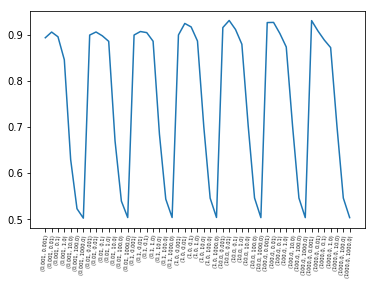

In [286]:
# ROC AUC vs. hyper parameters
# plt.figure(dpi=300)
sns.lineplot([x for x in range(49)], all_scores)
plt.xticks([x for x in range(49)], labels=parameter_combs, rotation=85,fontsize=5);

In [109]:
svc = SVC(C=10,gamma=.01,random_state=42, probability=True)
# scores = cross_val_score(svc, X_scaled_train, y_train, cv=5, scoring='roc_auc',n_jobs=-1)
# print(f'Final Score: {np.mean(scores)}')
svc.fit(X_scaled_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

0.9342174262640859

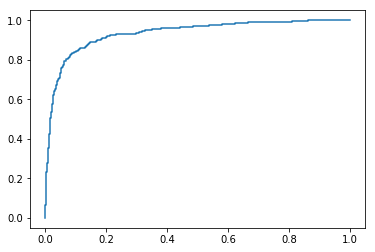

In [112]:
# ROC Curve
y_pred = svc.predict_proba(X_scaled_test)[:,1]
svc_fpr, svc_tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(svc_fpr,svc_tpr)
metrics.roc_auc_score(y_test, y_pred)

In [426]:
# with open('svc_1.pickle','wb') as f:
#     pickle.dump(svc, f)

0.6829494883577598

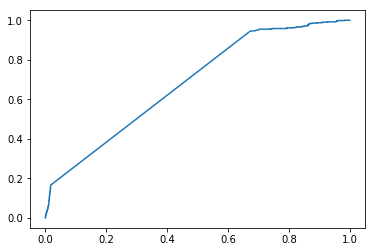

In [129]:
# ROC Curve
svc = SVC(C=100,gamma=10,random_state=42, probability=True)
svc.fit(X_scaled_resampled, y_scaled_resampled)
y_pred = svc.predict_proba(X_scaled_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr, tpr)
metrics.roc_auc_score(y_test, y_pred)

In [25]:
svc = SVC(C=100,gamma=10,random_state=42, probability=True)
svc.fit(X_scaled_resampled, y_scaled_resampled)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
y_pred = svc.predict_proba(X_scaled_test)[:,1]
# fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
# plt.plot(fpr,tpr)

In [29]:
metrics.roc_auc_score(y_test, y_pred)

0.6829494883577598

## Basic Decision Tree
- Hyper parameters: max_depth, max_features, min_samples_leaf, min_samples_split

In [382]:
# Experimenting with Hyperparameters to decide on ranges for grid search
decisiontree = DecisionTreeClassifier(class_weight=None, max_depth=5,
                                      max_features=, max_leaf_nodes=1000,
                                      min_samples_leaf=1, min_samples_split=.01,
                                      random_state=42)

scores = cross_val_score(decisiontree, X_train, y_train, cv=5, scoring='roc_auc',verbose=1)
print(np.mean(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9093302407694936


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [ ]:
# Manual Cross Fold Validation for Hyper Parameter Tuning- Logistic Regression
C_values= np.logspace(-3,3,7)
penalty_values = ['l1','l2']

lr_final_scores = []

for features,target in scaled_train_sets:
    all_scores = []
    parameter_combs = []
    for C in C_values:
        for p in penalty_values:
            lr = LogisticRegression(solver='liblinear',C=C,penalty=p,random_state=42, n_jobs=-1)
            scores = cross_val_score(lr, features,target, cv=5, scoring='roc_auc',n_jobs=-1)
            all_scores.append(np.mean(scores))
            parameter_combs.append((C,p))
        best_index = np.argmax(all_scores)
    
    print(f'The best hyper parameters are: {parameter_combs[best_index]}')
    print(f'The best score is: {all_scores[best_index]}')
    lr_final_scores.append({(parameter_combs[best_index],all_scores[best_index],best_index):all_scores})

In [377]:
### Grid Search of Decision Tree

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [x for x in range(2,15)],
    'max_features': [x for x in range(25,33)],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [.005, .01, .02, .03],
}

dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print(metrics.roc_auc_score(y_test, dt_grid.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 1248 candidates, totalling 6240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 775 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2375 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 3475 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 4775 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6217 out of 6240 | elapsed:  2.3min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 6240 out of 6240 | elapsed:  2.3min finished


0.9150784802958716


In [379]:
# Best Hyperparameter Values
dt_grid.best_params_

{'max_depth': 8,
 'max_features': 29,
 'min_samples_leaf': 5,
 'min_samples_split': 0.01}

In [ ]:
'mean_train_score'

In [395]:
dt_grid.cv_results_['mean_test_score']

array([0.82367573, 0.83124933, 0.82508955, ..., 0.9091846 , 0.9093374 ,
       0.90639999])

In [397]:
dt_grid.cv_results_['params']

[{'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.005},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.01},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.02},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.03},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.005},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.01},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.02},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.03},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 15,
  'min_samples_split': 0.005},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 15,
  'min_samples_split': 0.01},
 {'max_depth': 2,
  'max_features': 25,
 

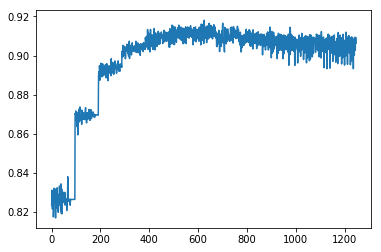

In [399]:
# ROC AUC vs. hyper parameters
# plt.figure(dpi=300)
sns.lineplot([x for x in range(1248)], dt_grid.cv_results_['mean_test_score'])
# plt.xticks([x for x in range(1248)], labels=parameter_combs, rotation=85,fontsize=5);

In [421]:
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1248 candidates, totalling 6240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1445 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2345 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 3445 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 4745 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6217 out of 6240 | elapsed:  2.2min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 6240 out of 6240 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'max_features': [25, 26, 27, 28, 29, 30, 31, 32], 'min_samples_leaf': [5, 10, 15], 'min_samples_split': [0.005, 0.01, 0.02, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

0.9139558842634133

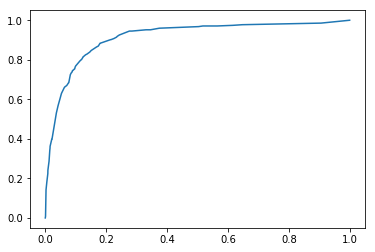

In [124]:
dt = DecisionTreeClassifier(max_depth= 8,
 max_features= 29,
 min_samples_leaf= 5,
 min_samples_split= 0.01)
dt.fit(X_train, y_train)

# ROC Curve
y_pred = dt.predict_proba(X_test)[:,1]
dt_fpr, dt_tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(dt_fpr,dt_tpr)
metrics.roc_auc_score(y_test, y_pred)

In [423]:
print(metrics.roc_auc_score(y_test, dt_grid.predict_proba(X_test)[:,1]))

0.9155694272343267


In [427]:
# with open('dt_grid_1.pickle','wb') as f:
#     pickle.dump(dt_grid, f)

### Random Decision Forest
- Hyperparameters: max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators

In [72]:
param_grid = {
    'max_depth': [x for x in range(2,15,2)],
    'max_features': [x for x in range(25,33,2)],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [.005, .01,.03],
    'class_weight':[None,{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:10}]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)
# print(metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 7560 out of 7560 | elapsed: 14.1min finished
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14], 'max_features': [25, 27, 29, 31], 'min_samples_leaf': [5, 10, 15], 'min_samples_split': [0.005, 0.01, 0.03], 'class_weight': [None, {0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 10}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [73]:
rf_grid.best_params_

{'class_weight': {0: 1, 1: 2},
 'max_depth': 14,
 'max_features': 25,
 'min_samples_leaf': 15,
 'min_samples_split': 0.005}

In [74]:
rf_grid.best_score_

0.9399508347334071

In [75]:
param_grid = {
    'max_depth': [x for x in range(2,15,2)],
    'max_features': [x for x in range(25,33,2)],
    'class_weight':[None,{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:10}]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)
# print(metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  1.9min finished
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14], 'max_features': [25, 27, 29, 31], 'class_weight': [None, {0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 10}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [76]:
rf_grid.best_params_

{'class_weight': None, 'max_depth': 10, 'max_features': 25}

In [77]:
rf_grid.best_score_

0.9394714706287515

In [81]:
param_grid = {
    'max_depth': [x for x in range(2,15,2)],
    'max_features': [x for x in range(25,33,2)],
    'class_weight':[None,{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:10}],
    'n_estimators':[150, 300, 500, 700, 1000, 1500]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)
# print(metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 38.4min
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarni

/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/extern

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14], 'max_features': [25, 27, 29, 31], 'class_weight': [None, {0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 10}], 'n_estimators': [150, 300, 500, 700, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [82]:
with open('rf_grid_1.pickle','wb') as f:
    pickle.dump(rf_grid, f)

In [83]:
rf_grid.best_params_

{'class_weight': None,
 'max_depth': 14,
 'max_features': 25,
 'n_estimators': 1500}

In [84]:
rf_grid.best_score_

0.947832105910655

In [93]:
len(rf_grid.cv_results_)

24

In [ ]:
rf 

In [113]:
rf = RandomForestClassifier(n_estimators=1500,max_depth= 14, max_features= 25,
                             class_weight=None, random_state=42,n_jobs=-1,)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [114]:
y_pred = rf.predict(X_test)

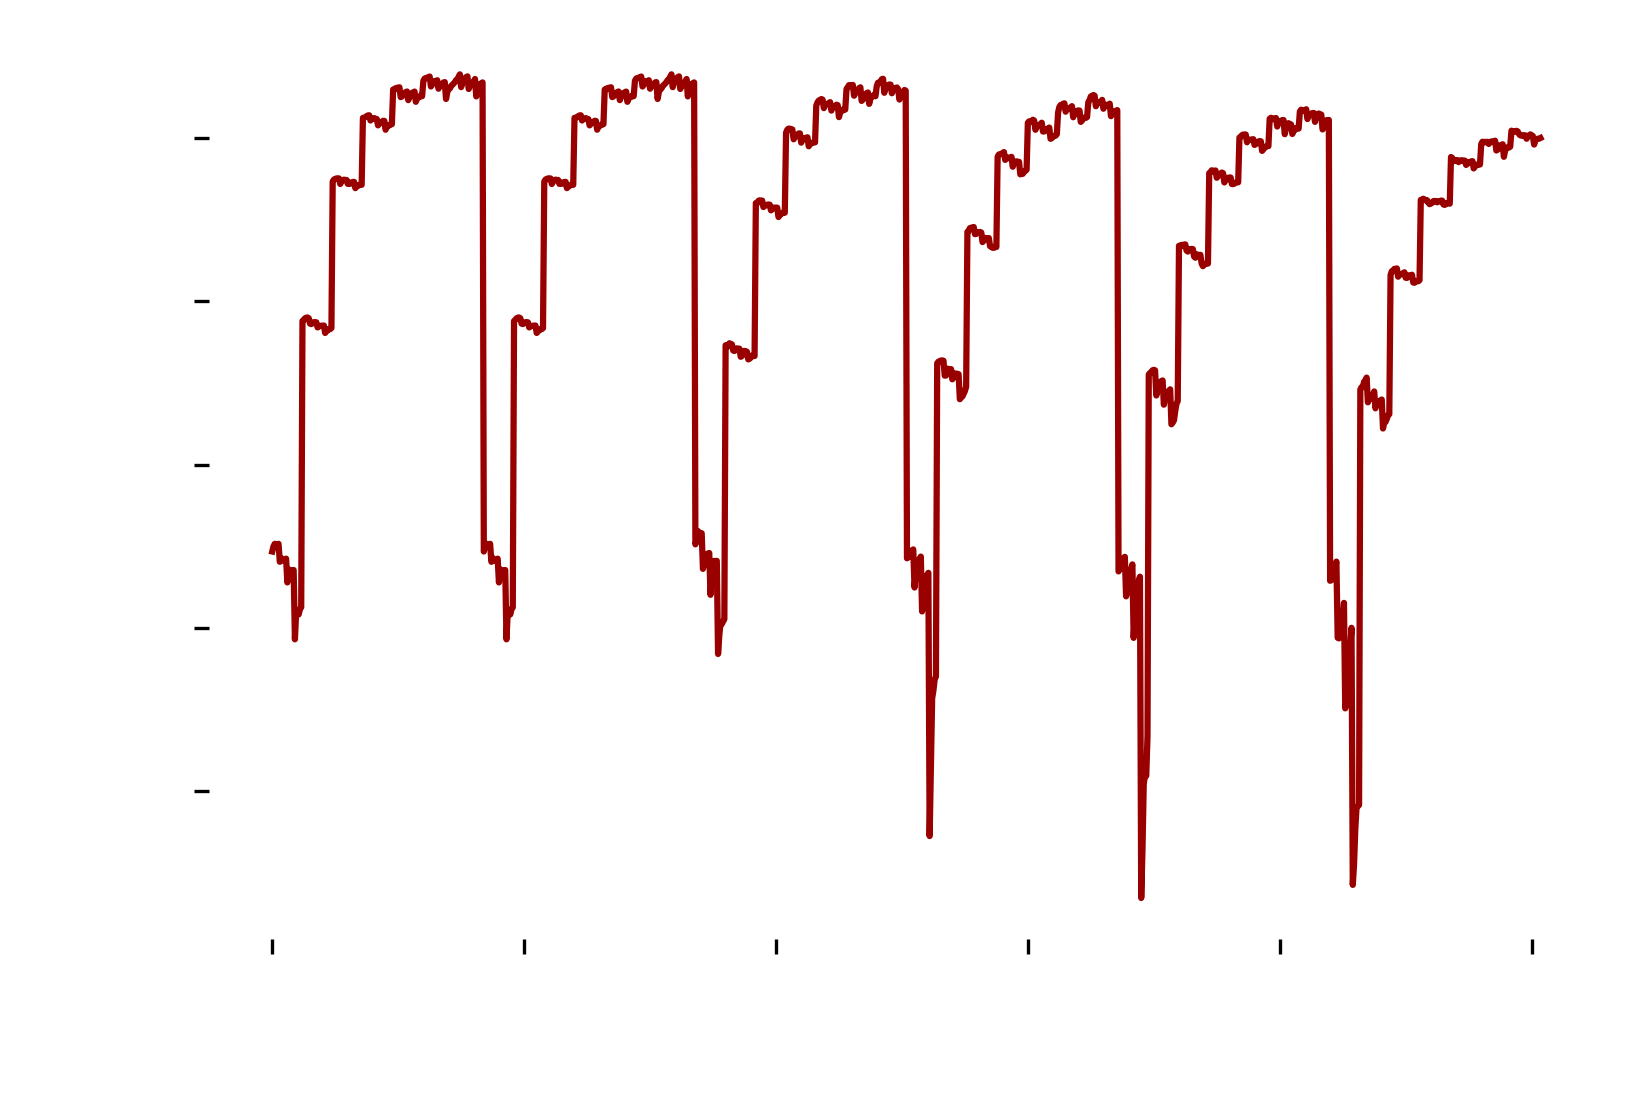

In [107]:
# ROC AUC vs. hyper parameters
plt.figure(dpi=300)
sns.lineplot([x for x in range(1008)], rf_grid.cv_results_['mean_test_score'], color='#990000ff')
plt.xlabel('Combinations of Hyperparameters', color='#FFFFFF')
plt.ylabel('ROC AUC', color='#FFFFFF')
plt.xticks(color='#FFFFFF')
plt.yticks(color='#FFFFFF')

sns.despine(left=True,bottom=True)
# plt.xticks([x for x in range(1248)], labels=parameter_combs, rotation=85,fontsize=5);

0.9520291969920816


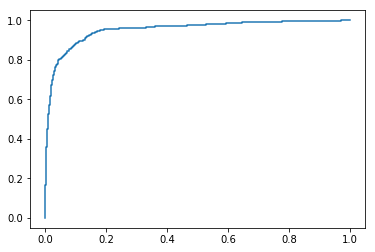

In [118]:
# ROC Curve
y_pred = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(rf_fpr,rf_tpr)
print(metrics.roc_auc_score(y_test, y_pred))

In [428]:
# with open('rf_1.pickle','wb') as f:
#     pickle.dump(rf, f)

### Determining Feature Importance Using Random Forest

In [119]:
important_index_list =  pd.Series(rf.feature_importances_).nlargest(10).index
important_values = pd.Series(rf.feature_importances_).nlargest(10).values

In [120]:
for x,y in zip([X.columns.values[i] for i in important_index_list],important_values):
    print(x,y)

ELEVATION 0.1754285976758008
max_snowfall_year 0.13204265522085015
max_temp_num_days_over_90 0.1079742719214525
max_temp_num_days_over_70 0.06361733603827471
precip_num_days_over_001 0.053771106974482716
total_precip_year 0.03477572458013248
total_snowfall_year 0.030582116491337227
max_temp_num_days_under_32 0.02650665112170522
min_temp_year 0.025585848740641244
snow_depth_num_days_over_1 0.02558214814272537


Final Model

### Determining Ideal Threshold Using Random Forest Model

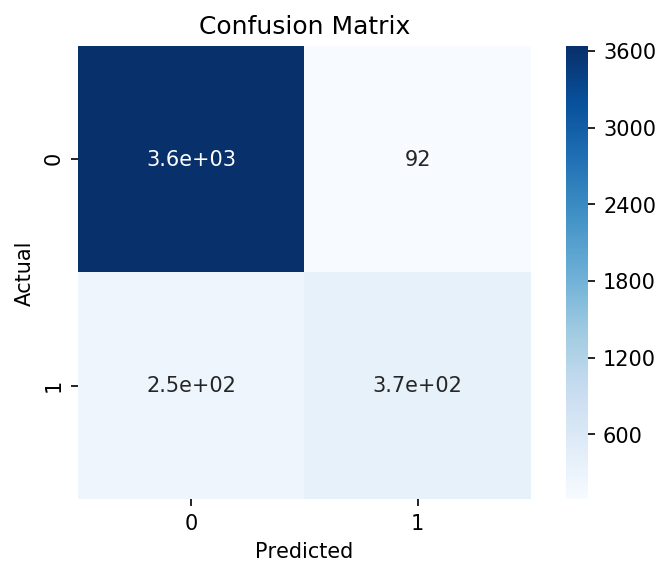

In [405]:
# Confusion Matrix BEFORE Threshold Adjustment
confusion = metrics.confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

# plt.savefig("confusion_matrix_logit_iris")

In [406]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.95      3731
         1.0       0.80      0.60      0.68       621

   micro avg       0.92      0.92      0.92      4352
   macro avg       0.87      0.79      0.82      4352
weighted avg       0.92      0.92      0.92      4352



regukarized svm, knn


### Quantifying Cost of Various Threshold

In [408]:
probabilties = rf.predict_proba(X_test)[:,1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


(array([2947.,  303.,  207.,  178.,  184.,  149.,  160.,  125.,   37.,
          62.]),
 array([8.95440052e-04, 9.22044673e-02, 1.83513495e-01, 2.74822522e-01,
        3.66131549e-01, 4.57440576e-01, 5.48749604e-01, 6.40058631e-01,
        7.31367658e-01, 8.22676685e-01, 9.13985713e-01]),
 <a list of 10 Patch objects>)

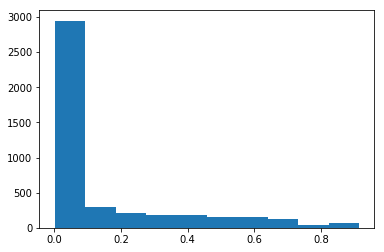

In [409]:
plt.hist(probabilties)

In [411]:
actual_target = y_test
best_threshold = 0
lowest_cost = 10000000

tp_cost = -4
fp_cost = 3
tn_cost = 0
fn_cost = 10

for threshold in np.linspace(0, 1, 101):
#     print(threshold)
    predictions = (probabilties >= threshold)
    
    tp = sum((actual_target == 1) & (predictions == 1))
    fp = sum((actual_target == 0) & (predictions == 1))
    tn = sum((actual_target == 0) & (predictions == 0))
    fn = sum((actual_target == 1) & (predictions == 0))
    
    total_cost = (tp*tp_cost + fp*fp_cost + tn*tn_cost + fn*fn_cost)
    
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold
print('The best threshold is {}'.format(best_threshold))

The best threshold is 0.28


In [413]:
new_threshold_pred = []
for prob in probabilties:
    if prob >= 0.28:
        new_threshold_pred.append(1)
    else:
        new_threshold_pred.append(0)


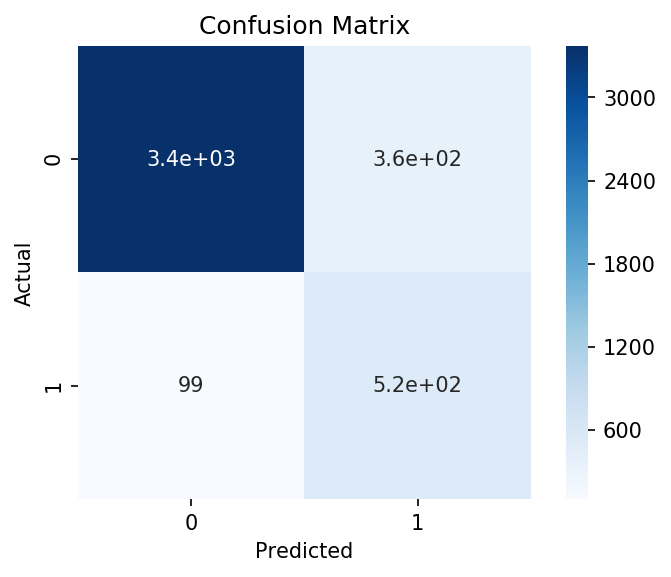

In [415]:
# Confusion Matrix AFTER Threshold Adjustment
confusion = metrics.confusion_matrix(y_test, new_threshold_pred)
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

# plt.savefig("confusion_matrix_logit_iris")

In [417]:
print(metrics.classification_report(y_test,new_threshold_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94      3731
         1.0       0.59      0.84      0.69       621

   micro avg       0.89      0.89      0.89      4352
   macro avg       0.78      0.87      0.82      4352
weighted avg       0.92      0.89      0.90      4352



### Saturday Todo:
- Quantify the relative benefit and cost of f/t p/n
- Manually build grid search for other models first
    - look into the importance of different hyper parameters for each model
- after this, build a pipeline using sklearn
    - include ROC curve graphs, and other visualizations for comparison
    - add in oversampling,smote etc
- do feature engineering/ removing colinearity
- add in other county level dat such as demographics(age, race, urban vs rural, outdoor recreation levels, federal lands, 

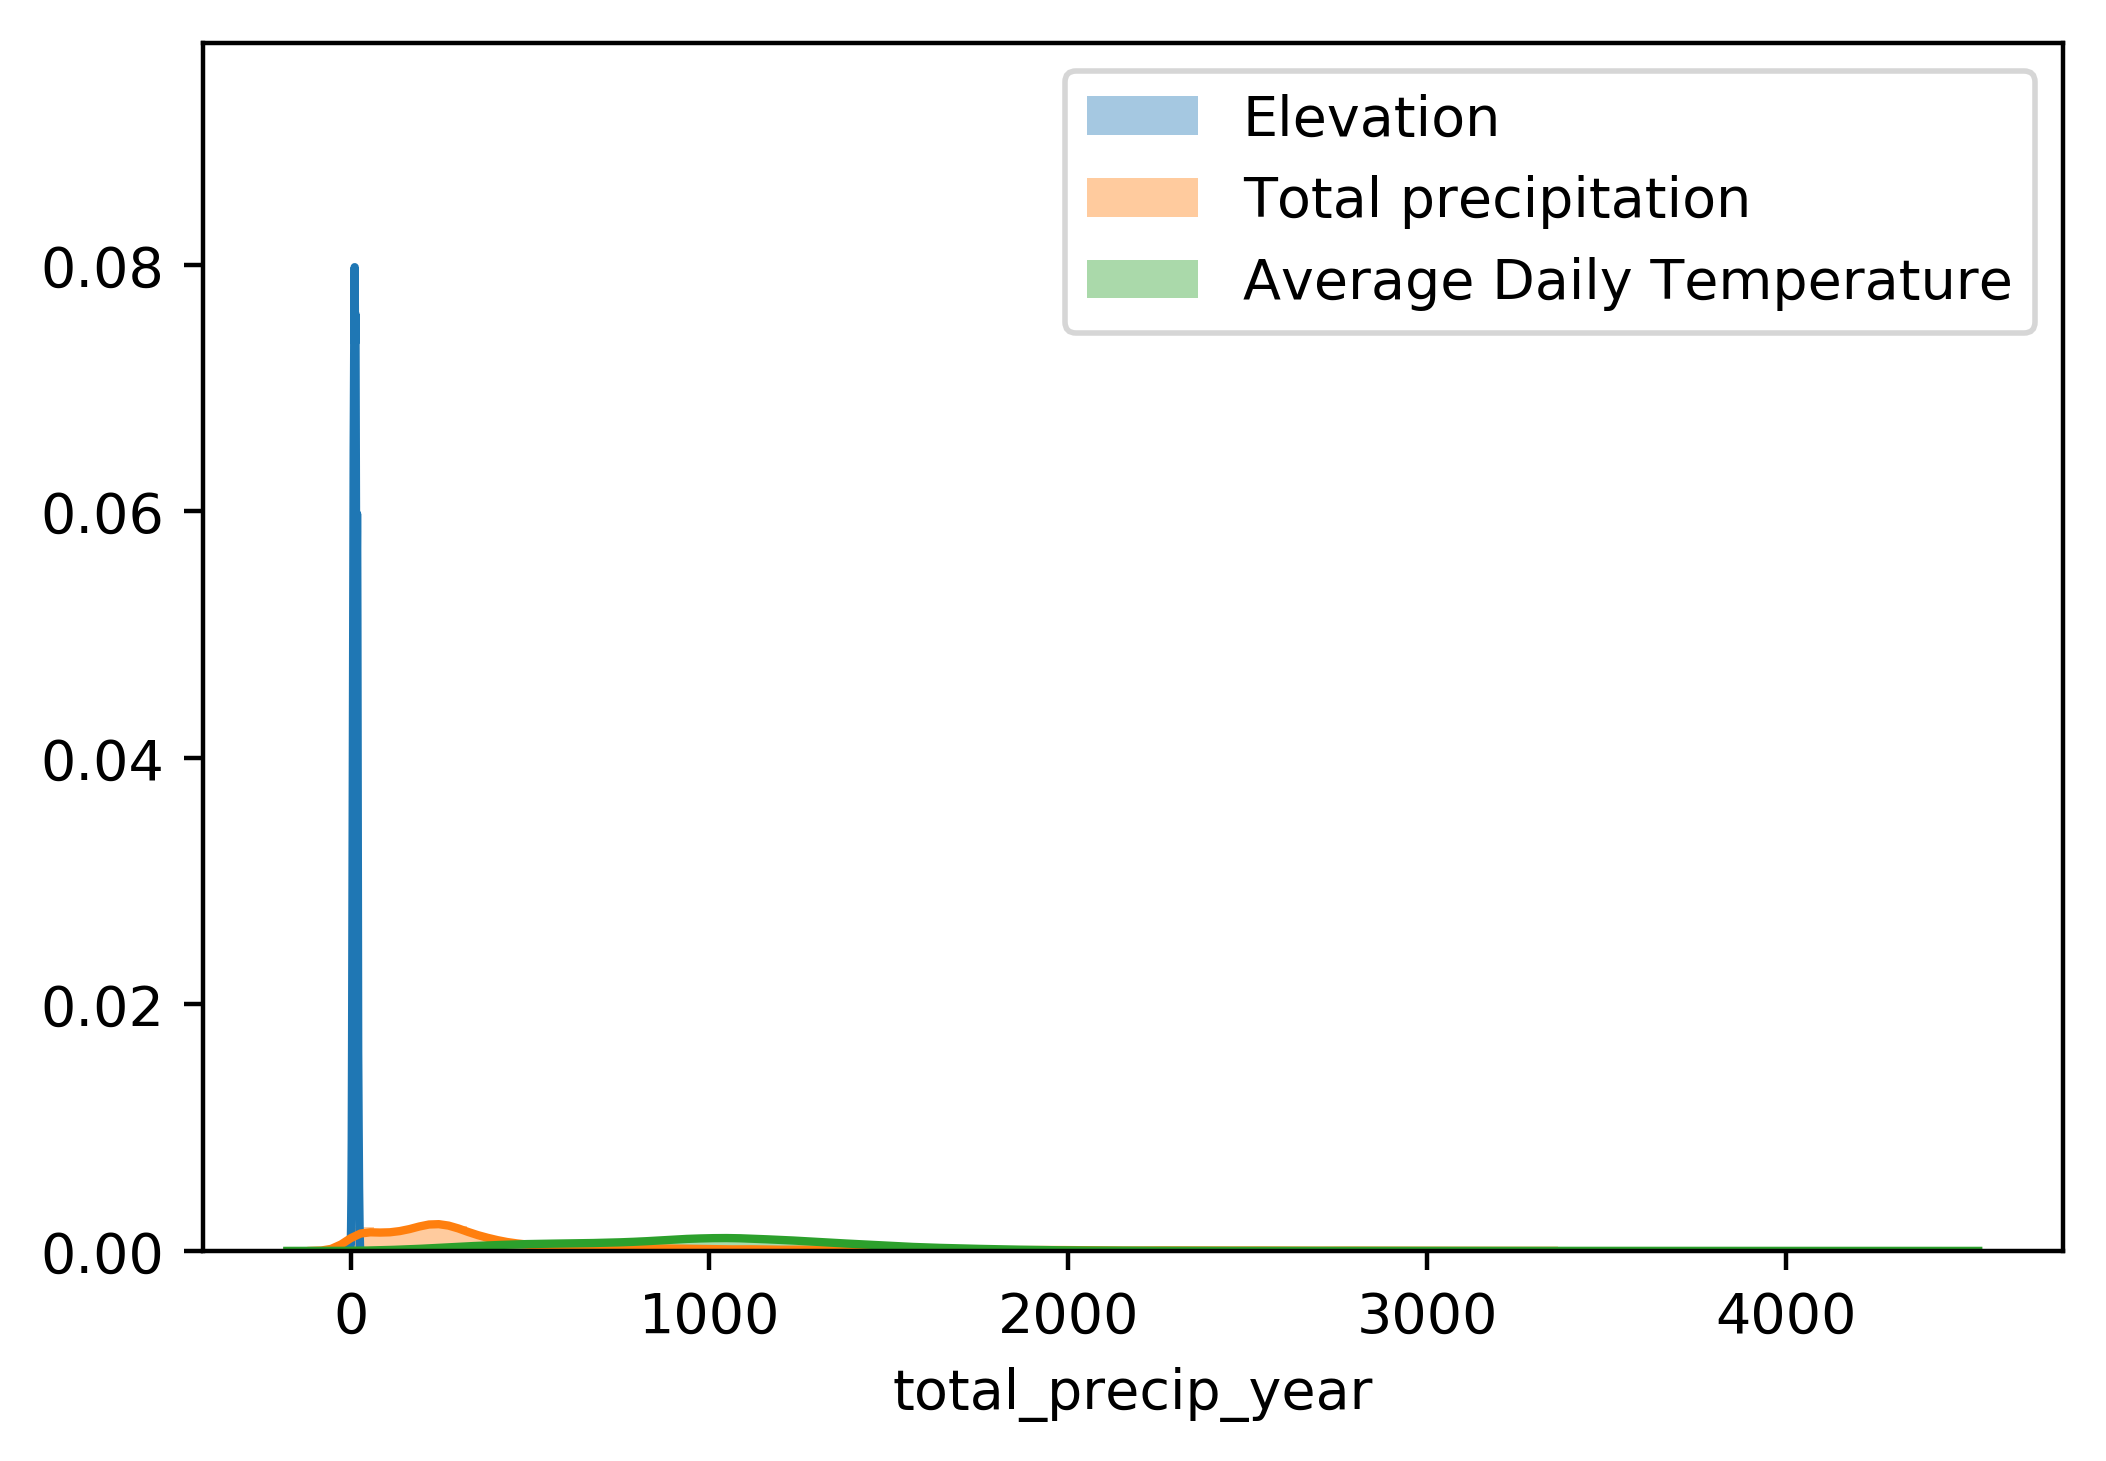

In [139]:
plt.figure(dpi=400)
column_names = ['Elevation','Total precipitation','Average Daily Temperature']
sns.distplot(df.ELEVATION)
sns.distplot(df.total_precip_year)
sns.distplot(df.avg_daily_temp_year)
plt.legend(column_names)